In [1]:
!unzip '/content/drive/MyDrive/ML Datasets/Fer 2013 csv.zip'

Archive:  /content/drive/MyDrive/ML Datasets/Fer 2013 csv.zip
  inflating: fer2013.csv             


In [2]:
#Import ML required packages
import numpy as np
import pandas as pd
import keras
from keras.utils import to_categorical
#Import Libraries before model creation
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
#Load and Read the dataset
emotion_data = pd.read_csv('/content/fer2013.csv')
print('Dataset loaded successfully')

Dataset loaded successfully


In [4]:
emotion_data.head()

,emotion,pixels,Usage
0,5.0,38 44 66 67 74 76 47 38 45 39 38 31 37 49 70 6...,PrivateTest
1,2.0,9 17 67 93 103 144 191 208 215 218 209 191 178...,PrivateTest
2,4.0,254 255 255 254 254 255 249 255 163 3 5 5 0 0 ...,PrivateTest
3,6.0,255 253 254 207 125 120 38 33 18 39 31 22 21 2...,PrivateTest
4,5.0,253 253 254 253 170 101 105 102 85 91 120 141 ...,PrivateTest


In [5]:
emotion_data.tail()

,emotion,pixels,Usage
30154,3.0,60 60 62 79 74 91 92 70 86 129 149 166 185 189...,PrivateTest
30155,3.0,134 132 124 128 132 128 129 140 59 17 23 11 14...,PrivateTest
30156,3.0,79 92 128 131 84 80 98 137 129 139 170 162 154...,PrivateTest
30157,0.0,106 101 99 97 94 91 87 82 75 61 38 22 20 23 19...,PrivateTest
30158,2.0,254 255 252 253 252 252 254 253 255 253 248 12...,PrivateTest


In [6]:
emotion_data.Usage.value_counts()

Usage
PrivateTest    27168
Training        2991
Name: count, dtype: int64

In [7]:
#Pull out dataset in different categories
data_train = emotion_data[emotion_data['Usage']== 'PrivateTest'].copy()
data_val = emotion_data[emotion_data['Usage']=='Training'].copy()
data_test = emotion_data[emotion_data['Usage']=='Training'].copy()

In [8]:
print('Train shape: {}\nValidation shape: {}\nTest shape: {}'.format(data_train.shape,data_val.shape,data_test.shape))

Train shape: (27168, 3)
Validation shape: (2991, 3)
Test shape: (2991, 3)


In [9]:
#Initialize Parameters
num_classes = 7
epochs = 55
batch_size = 64
num_features = 32
width, height = 48,48

In [10]:
emotion_data.shape
emotion_data.describe()
#checking for missing values
emotion_data.isna().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

<Axes: ylabel='Count'>

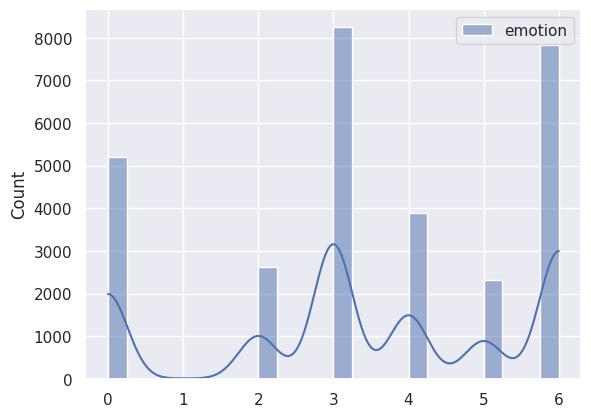

In [11]:
sns.set_theme(style='darkgrid', palette='deep', font='sans-serif', font_scale=1)
sns.histplot(data= emotion_data,kde = True)

In [12]:
#Data Preprocessing
#Perform CRNO (CRNO stands for Convert,Reshape, Normalize, one-hot-encoding)
def CRNO(df,dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(),dtype='float32').reshape(-1,width,height,1)/255.0
    data_Y = to_categorical(df['emotion'],num_classes)
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X,data_Y

In [13]:
train_X,train_Y = CRNO(data_train,'train')
val_X,val_Y = CRNO(data_val,'validation')
test_X,test_Y = CRNO(data_test,'test')

train _X shape: {},  train _Y shape: (27168, 48, 48, 1)
validation _X shape: {},  validation _Y shape: (2991, 48, 48, 1)
test _X shape: {},  test _Y shape: (2991, 48, 48, 1)


In [14]:
#Build the model
model = Sequential()
#Module1 conv<<conv<<batchnorm<<relu<<maxpooling<<dropout
model.add(Conv2D(2*num_features,kernel_size=(3,3),padding='same',data_format='channels_last',input_shape=(width, height, 1)))
model.add(Conv2D(2*num_features,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.2))
#Module2 conv<<conv<<batchnorm<<relu<<maxpool<<dropout
model.add(Conv2D(2*2*num_features,kernel_size=(3,3),padding='same'))
model.add(Conv2D(2*2*num_features,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.2))
#Module3 conv<<conv<<batchnorm<<relu<<maxpool<<dropout
model.add(Conv2D(2*2*2*num_features,kernel_size=(1,1),padding='same'))
model.add(Conv2D(2*2*2*num_features,kernel_size=(1,1),strides=(2,2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.2))
#Module4 fc<<batchnorm<<fc<<batchnorm<<dropout<<softmax
model.add(Flatten())
model.add(Dense(units=128))
model.add(BatchNormalization())
model.add(Dense(units=128))
model.add(BatchNormalization())
model.add(Dropout(rate=0.2))
model.add(Dense(num_classes,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999),metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0

In [15]:
#Training the model
es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

history = model.fit(train_X,train_Y,batch_size=batch_size,epochs=100,verbose=2,callbacks=[es],validation_split=0,validation_data=(val_X,val_Y),shuffle=True)

Epoch 1/100
425/425 - 28s - loss: 1.7033 - accuracy: 0.3542 - val_loss: 1.9272 - val_accuracy: 0.2912 - 28s/epoch - 65ms/step
Epoch 2/100
425/425 - 14s - loss: 1.3649 - accuracy: 0.4723 - val_loss: 1.6202 - val_accuracy: 0.3842 - 14s/epoch - 34ms/step
Epoch 3/100
425/425 - 14s - loss: 1.2563 - accuracy: 0.5140 - val_loss: 1.3574 - val_accuracy: 0.4724 - 14s/epoch - 34ms/step
Epoch 4/100
425/425 - 14s - loss: 1.2044 - accuracy: 0.5361 - val_loss: 1.2868 - val_accuracy: 0.4875 - 14s/epoch - 34ms/step
Epoch 5/100
425/425 - 15s - loss: 1.1685 - accuracy: 0.5479 - val_loss: 1.1873 - val_accuracy: 0.5326 - 15s/epoch - 36ms/step
Epoch 6/100
425/425 - 15s - loss: 1.1413 - accuracy: 0.5604 - val_loss: 1.1517 - val_accuracy: 0.5550 - 15s/epoch - 34ms/step
Epoch 7/100
425/425 - 15s - loss: 1.1257 - accuracy: 0.5641 - val_loss: 1.2489 - val_accuracy: 0.5289 - 15s/epoch - 34ms/step
Epoch 8/100
425/425 - 14s - loss: 1.1094 - accuracy: 0.5722 - val_loss: 1.1968 - val_accuracy: 0.5369 - 14s/epoch - 34

In [16]:
loss_and_metrics = model.evaluate(test_X,test_Y)
print(loss_and_metrics)

#Evaluate the test performance
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

94/94 [==============================] - 1s 9ms/step - loss: 1.0666 - accuracy: 0.5861
[1.0666301250457764, 0.5860916376113892]
94/94 [==============================] - 1s 4ms/step
CNN Model Accuracy on test set: 0.5861


In [20]:
# Save the model
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
# Loading the best fit model
from keras.models import load_model
model = load_model("/content/model.h5")

h =  history.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

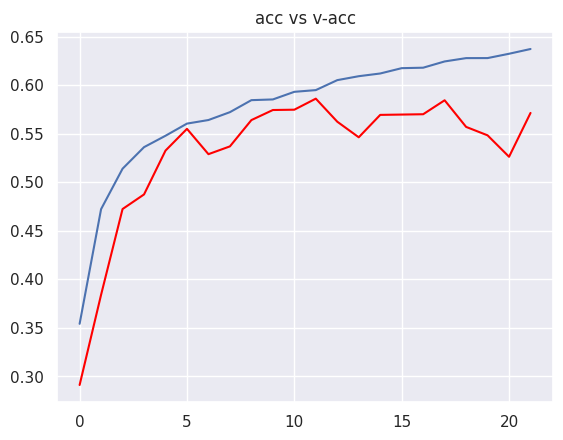

In [22]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

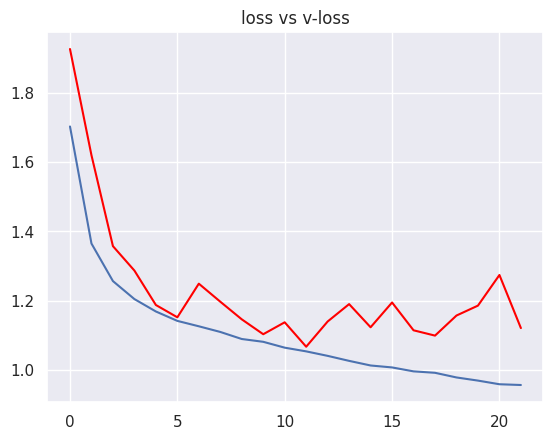

In [23]:
plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()